## Preprocessing

In [21]:
from datetime import datetime
import os
import warnings

from matplotlib import rc
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
import sympy as sp

from qaoa_solver import QAOASolver
from utils import compute_solution, compute_fidelity, get_pennylane_layer


pd.set_option('display.max_columns', None)

ticks_formatter = FuncFormatter(lambda x, _: f"${x:g}$")

In [22]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        result['filepath'] = result_file
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state'] = experiment_results['state'].apply(lambda st: np.array([complex(c) for c in st]))
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)
#experiment_results['cost'] = experiment_results.apply(lambda row: row['cost']**2 if row['cost_hamiltonian']=='abs_H' else row['cost'], axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]

Ns = sorted(experiment_results['N'].unique())
problem_Hs = sorted(experiment_results['problem_hamiltonian'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['energy_max'] = experiment_results['Ec'].apply(lambda E: np.max(E))
experiment_results['energy_norm'] = experiment_results['Ec'].apply(lambda E: np.linalg.norm(E))
experiment_results['energy_avg'] = experiment_results['Ec'].apply(lambda E: np.average(E))

# For computing H_QP cost in linear_abs protocol
quadratic_energies = energies_df[energies_df['cost_hamiltonian']=='quadratic_H'][['N', 'Ec']]
quadratic_energies = quadratic_energies.rename(columns={'Ec': 'quadratic_Ec'})
experiment_results = experiment_results.merge(quadratic_energies, how='left', on='N')

experiment_results['normalized_cost'] = experiment_results.apply(
    lambda row: np.vdot(row['state'], row['quadratic_Ec'] * row['state']).real
        if row['cost_hamiltonian']=='abs_H'
        else row['cost'], axis=1)

max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['normalized_cost'].max().reset_index()
max_costs = max_costs.rename(columns={'normalized_cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['cost_rescaled'] = experiment_results['normalized_cost'] / experiment_results['max_cost']

dfs = []
for N, nx, ny in experiment_results[['N', 'nx', 'ny']].drop_duplicates().sort_values('N').itertuples(index=False):
    for Hp in problem_Hs:
        gate_sizes = dict(qml.specs(get_pennylane_layer(N, nx, ny, Hp), level=None)()['resources'].gate_sizes)
        dfs.append(pd.DataFrame({'N': [N], 'problem_hamiltonian': [Hp], 'gate_sizes': [gate_sizes]}))
gates_df = pd.concat(dfs, ignore_index=True)
experiment_results = experiment_results.merge(gates_df, how='left', on=['N', 'problem_hamiltonian'])

experiment_results['num_2qub_gates_layer'] = experiment_results['gate_sizes'].apply(lambda s: s[2]*2 + s.get(3,0)*4 + s.get(4,0)*6)
experiment_results['num_2qub_gates'] = experiment_results.apply(lambda row: row['num_2qub_gates_layer']*row['layers'], axis=1)

### Plotting

In [23]:
markers = ['o', "s", "D", "p", "v", "^", "X", "<", ">", "H","o", "s", "D", "p", "v", "^", "X", "<", ">", "H"]

plot_colors = [
    #[Dark ,    light]
    ["#000000",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
]


rc('font', family='Times New Roman', size=16)
rc('mathtext', fontset='cm')
rc('lines', linewidth=4, markersize=8, markeredgewidth=1.5)
rc('axes', labelsize=14, titlesize=16)
rc('legend', fontsize=12, title_fontsize=12)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

## Optimizer Comparison

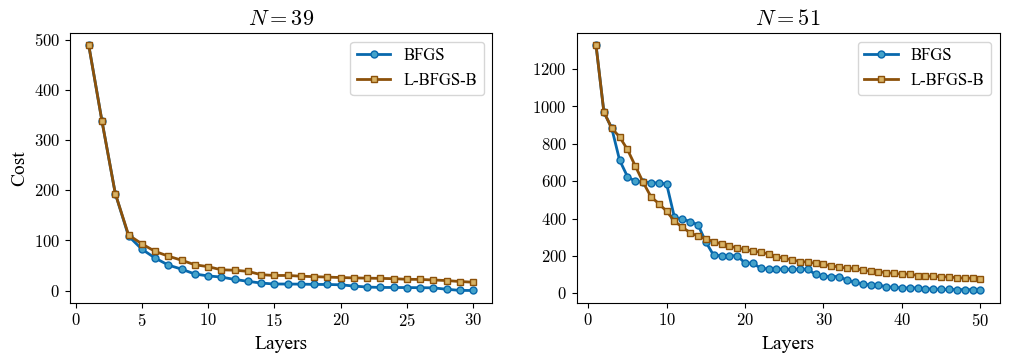

In [73]:
Ns = [39,51]

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))

for j, N in enumerate(Ns):
    ax = axs.flatten()[j]
    df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
    max_layers = int(df['layers'].max())

    for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
        df_i = df[df['optimizer']==optimizer]
        ax.plot(
            'layers', 'cost', data=df_i, label=optimizer,
            color=plot_colors[-i-1][0],
            marker=markers[i], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[-i-1][0], mfc=plot_colors[-i-1][1]
        )

    ax.set_xlabel('Layers')
    if j==0:
        ax.set_ylabel('Cost')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

plt.savefig('plots/optimizer_comparison.pdf', format='pdf', bbox_inches='tight')

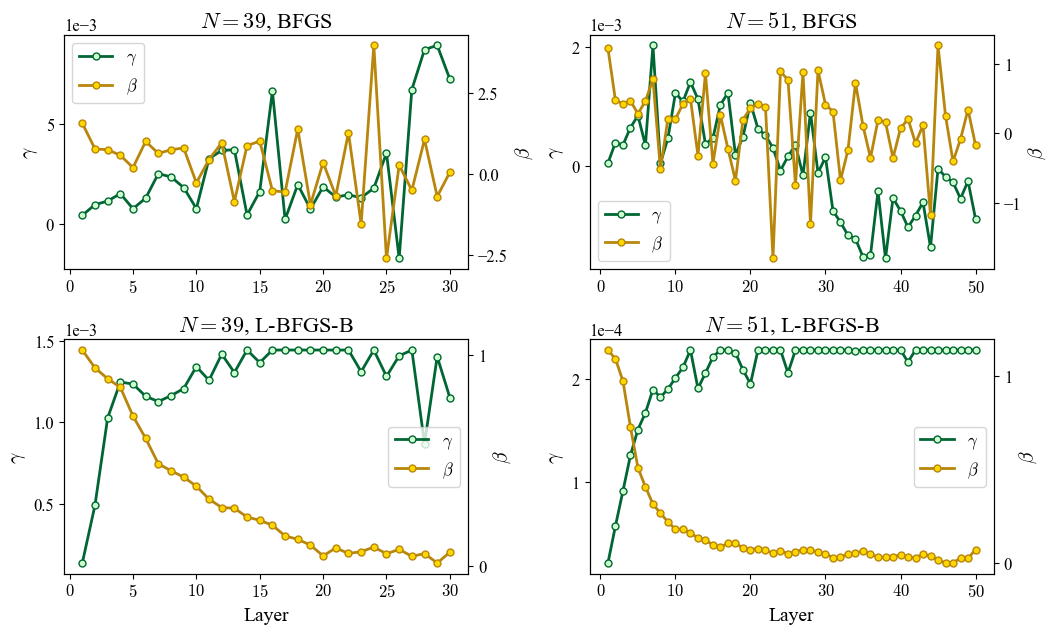

In [30]:
Ns = [39,51]

fig, axs = plt.subplots(2, 2, figsize=(12, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, N in enumerate(Ns):
    df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
    max_layers = int(df['layers'].max())

    for j, optimizer in enumerate(sorted(df['optimizer'].unique())):
        ax = axs[j][i]
        df_i = df[df['optimizer']==optimizer]
        max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
        max_layer = df_i.loc[max_layer_idx, 'layers']
        gammas = df_i.loc[max_layer_idx, 'gammas']
        betas = df_i.loc[max_layer_idx, 'betas']
        
        ax.plot(
            range(1, max_layer+1), gammas, label='$\\gamma$',
            color=plot_colors[3][0],
            marker='o', markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[3][0], mfc=plot_colors[3][1])
        
        twin = ax.twinx()
        twin.plot(
            range(1, max_layer+1), betas, label='$\\beta$',
            color=plot_colors[4][0],
            marker='o', markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[4][0], mfc=plot_colors[4][1])
        
        if j==1:
            ax.set_xlabel('Layer')
        
        ax.set_ylabel('$\\gamma$')
        twin.set_ylabel('$\\beta$')

        ax.set_title(f'$N = {N}$, {optimizer}')
        ax.xaxis.set_major_formatter(ticks_formatter)

        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,1))
        ax.locator_params(axis='y',nbins=2)
        twin.locator_params(axis='y',nbins=2)
        
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = twin.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='center right' if optimizer=='L-BFGS-B'
                  else 'upper left' if N==39 else 'lower left')
        
plt.savefig('plots/optimizer_parameters_comparison.pdf', format='pdf', bbox_inches='tight')

## Results

First, let's see the maximum fidelities achieved by the different protocols.

In [24]:
df = experiment_results[experiment_results['optimizer']=='BFGS']
max_fidelities = df.groupby(['N','setup'])['fidelity'].max()
df = df.merge(max_fidelities, how='inner', on=['N','setup', 'fidelity'])
df.groupby(['N', 'setup']).agg({
    'layers': 'min',
    'num_2qub_gates': 'min',
    'fidelity': 'first'
}).pivot_table(values='fidelity', index='setup', columns='N')

N,15,21,35,39,51,77,87,95,115,119,143
setup,,,,,,,,,,,
linear_abs,1.0,1.0,0.996695,0.999976,0.992734,0.985991,0.979239,0.849321,0.020515,0.022510,0.008592
linear_quadratic,1.0,1.0,0.968217,0.999791,1.000000,0.944180,0.666109,0.156931,0.006714,0.158496,0.009127
standard,1.0,1.0,0.864901,0.982655,0.250125,0.401879,0.103895,0.105131,0.047626,0.055460,0.049183


In [25]:
df.groupby(['N', 'setup']).agg({
    'layers': 'min',
    'num_2qub_gates': 'min',
    'fidelity': 'first'
})

layers  num_2qub_gates  fidelity
N   setup                                             
15  linear_abs             8              32  1.000000
    linear_quadratic       8              32  1.000000
    standard               7              70  1.000000
21  linear_abs             8              32  1.000000
    linear_quadratic       9              36  1.000000
    standard               7              70  1.000000
35  linear_abs            30             360  0.996695
    linear_quadratic      30             360  0.968217
    standard              30            2220  0.864901
39  linear_abs            30             360  0.999976
    linear_quadratic      30             360  0.999791
    standard              30            2220  0.982655
51  linear_abs            50             800  0.992734
    linear_quadratic      64            1024  1.000000
    standard              38            4940  0.250125
77  linear_abs            50             800  0.985991
    linear_quadratic      49             784  0.944180
    standard              48            6240  0.401879
87  linear_abs            73            1752  0.979239
    linear_quadratic      70            1680  0.666109
    standard              70           18900  0.103895
95  linear_abs            99            2376  0.849321
    linear_quadratic      89            2136  0.156931
    standard              60           16200  0.105131
115 linear_abs             3              90  0.020515
    linear_quadratic       4             120  0.006714
    standard              68           28288  0.047626
119 linear_abs             8             240  0.022510
    linear_quadratic      43            1290  0.158496
    standard              62           25792  0.055460
143 linear_abs             1              30  0.008592
    linear_quadratic       1              30  0.009127
    standard              58           24128  0.049183

### Normalized Cost vs Layers

Cost given by $\langle |H_\mathrm{LP}| \rangle$ is not directly comparable with the cost given by
$\langle H_\mathrm{QP} \rangle$. Given a state $\ket{\psi}$,
$$\langle |H_\mathrm{LP}|^2 \rangle_\psi = \langle H_\mathrm{QP} \rangle_\psi \Longrightarrow
\langle |H_\mathrm{LP}| \rangle_\psi^2 \neq \langle H_\mathrm{QP} \rangle_\psi$$
so we cannot just square the cost when using the linear\_abs protocol to compare it to the standard protocol.

Instead, we can perform a cross-evaluation. That is, for the linear\_abs protocol, we compute the cost that we
would have obtained for the linear\_quadratic protocol, i.e. $\langle H_\mathrm{QP} \rangle$, given that
we have access to the state.

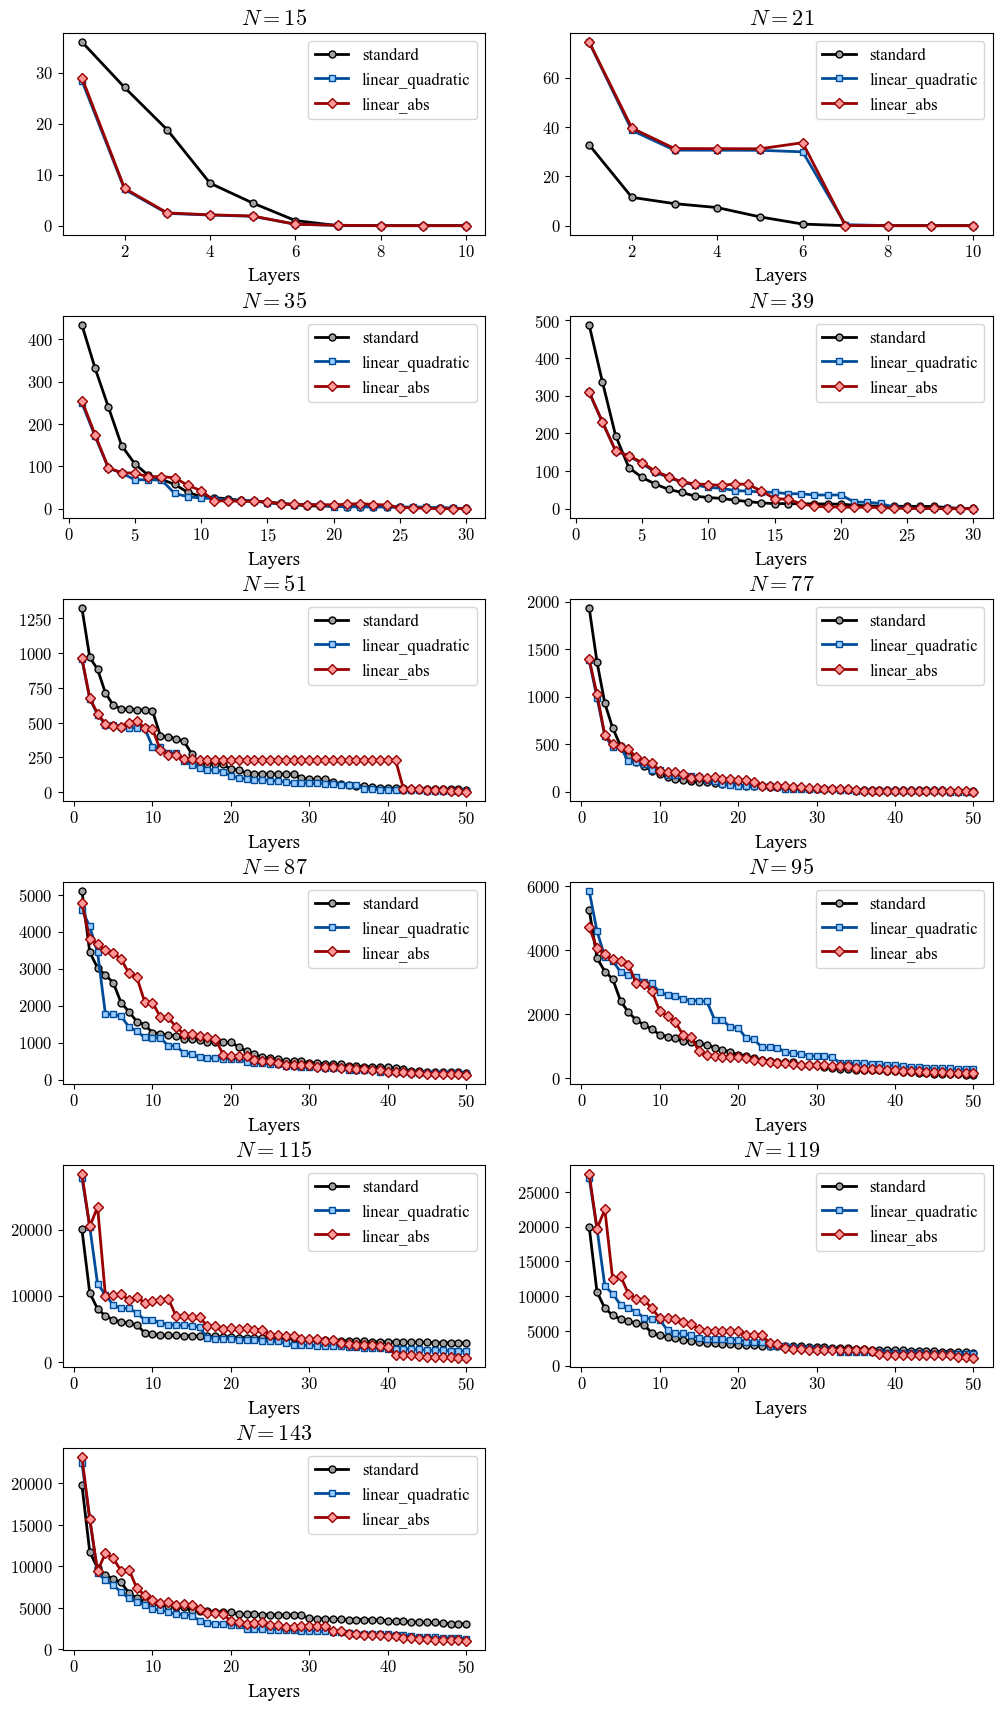

In [50]:
Ns = sorted(experiment_results['N'].unique())

ncols = 2
nrows = int(np.ceil(len(Ns)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows))
fig.subplots_adjust(hspace=0.4)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'normalized_cost', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    ax.set_xlabel('Layers')
    if j==0:
        ax.set_ylabel('Cost')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

for k in range(len(Ns), len(axs.flatten())):
    axs.flatten()[k].remove()

plt.savefig('plots/cost_layers_raw.pdf', format='pdf', bbox_inches='tight')

### Normalized Cost vs Gates (log scale)

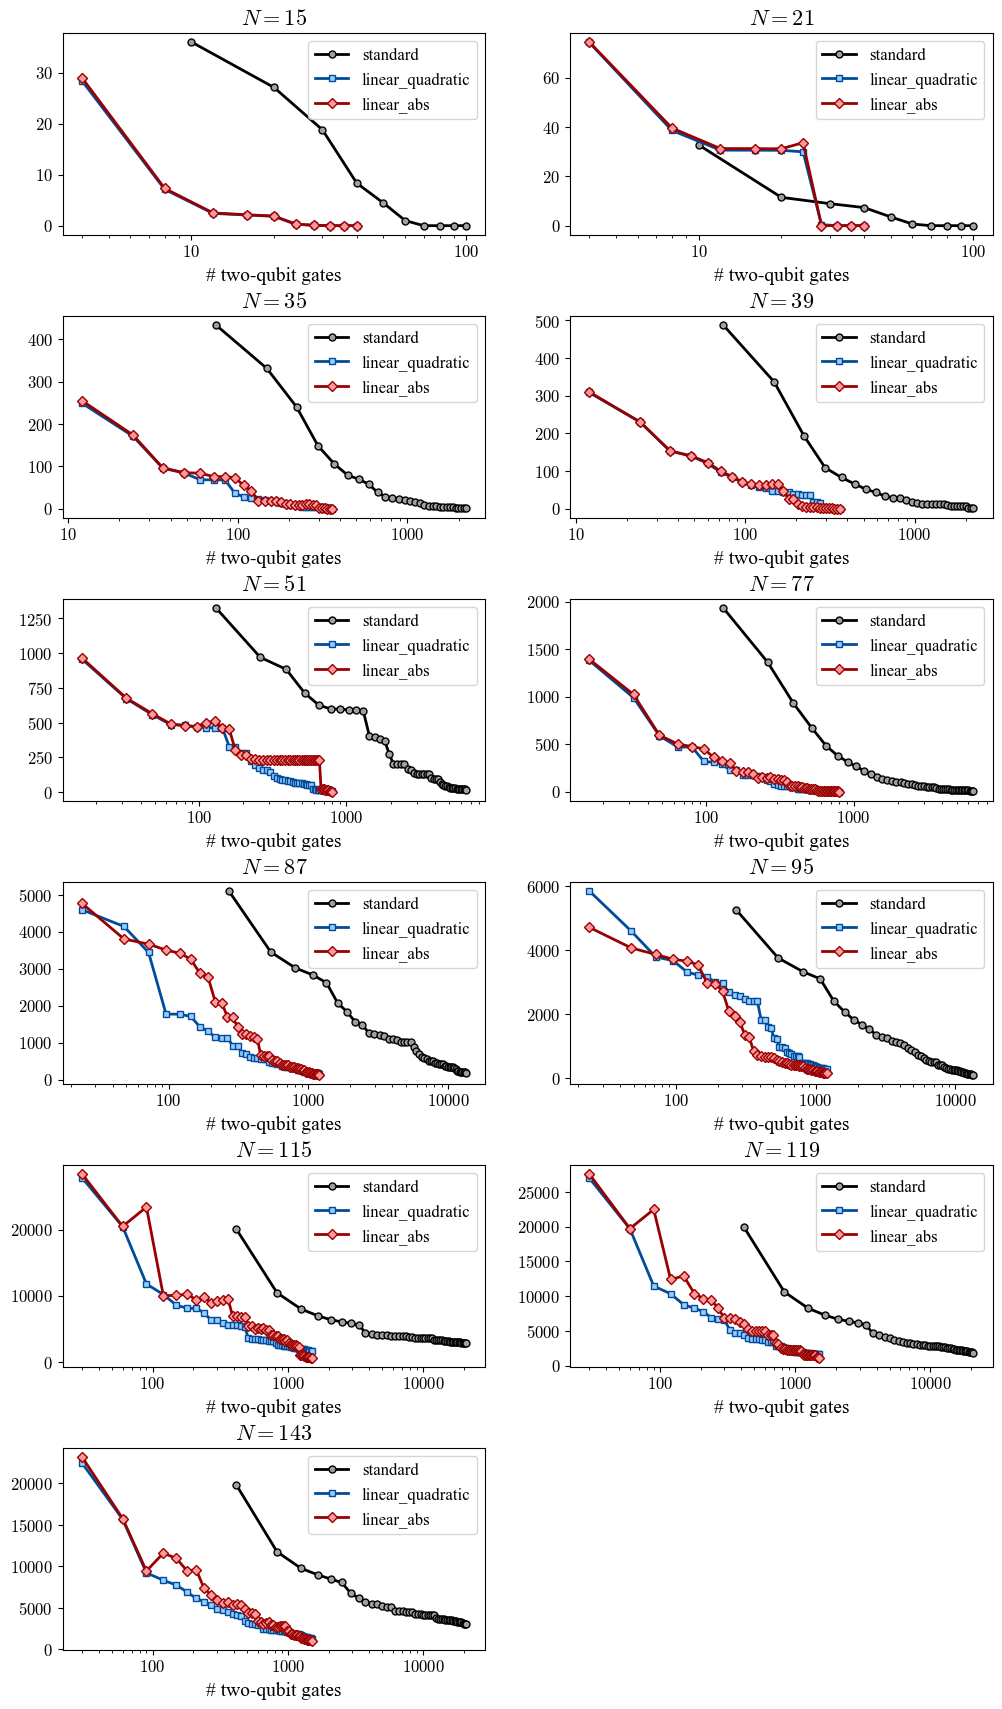

In [51]:
Ns = sorted(experiment_results['N'].unique())

ncols = 2
nrows = int(np.ceil(len(Ns)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows))
fig.subplots_adjust(hspace=0.4)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'num_2qub_gates', 'normalized_cost', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )
        ax.set_xscale('log')

    ax.set_xlabel('# two-qubit gates')
    if j==0:
        ax.set_ylabel('Cost')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

for k in range(len(Ns), len(axs.flatten())):
    axs.flatten()[k].remove()

plt.savefig('plots/cost_gates_raw_logscale.pdf', format='pdf', bbox_inches='tight')

### Fidelity (success probability) vs Layers

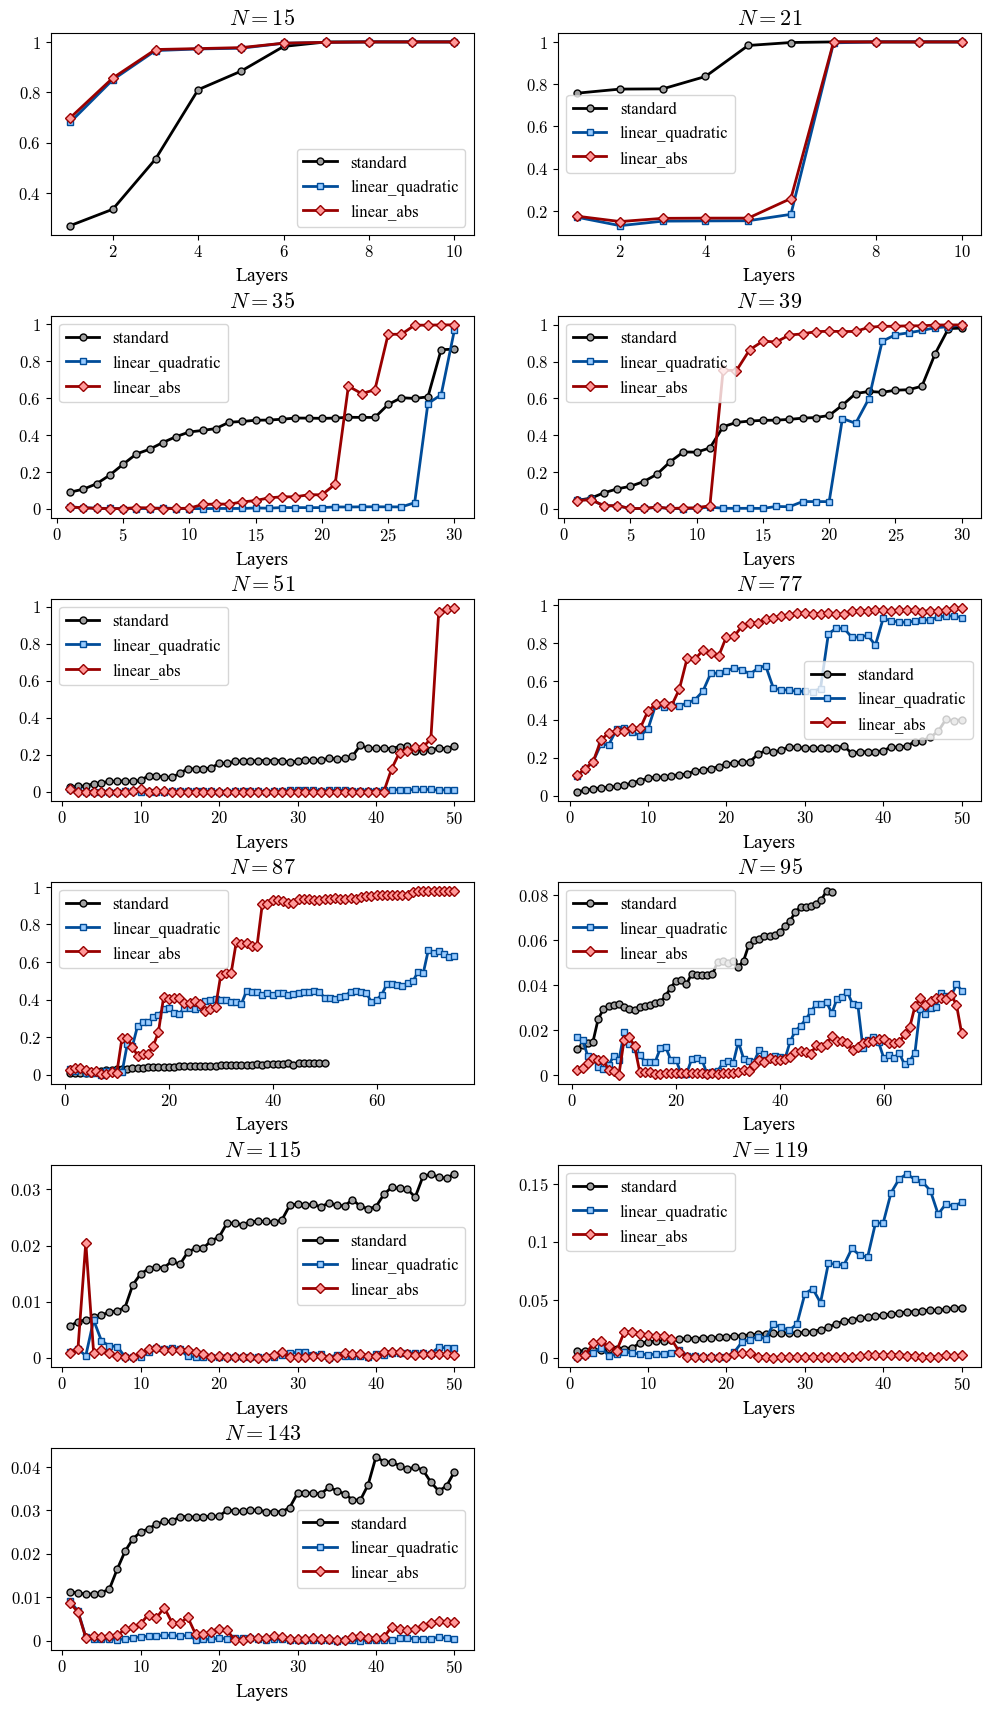

In [6]:
Ns = sorted(experiment_results['N'].unique())

ncols = 2
nrows = int(np.ceil(len(Ns)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows))
fig.subplots_adjust(hspace=0.4)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    ax.set_xlabel('Layers')
    if j==0:
        ax.set_ylabel('Fidelity')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

for k in range(len(Ns), len(axs.flatten())):
    axs.flatten()[k].remove()

plt.savefig('plots/fidelity_layers_raw.pdf', format='pdf', bbox_inches='tight')

### Fidelity (success probability) vs Gates (log scale)

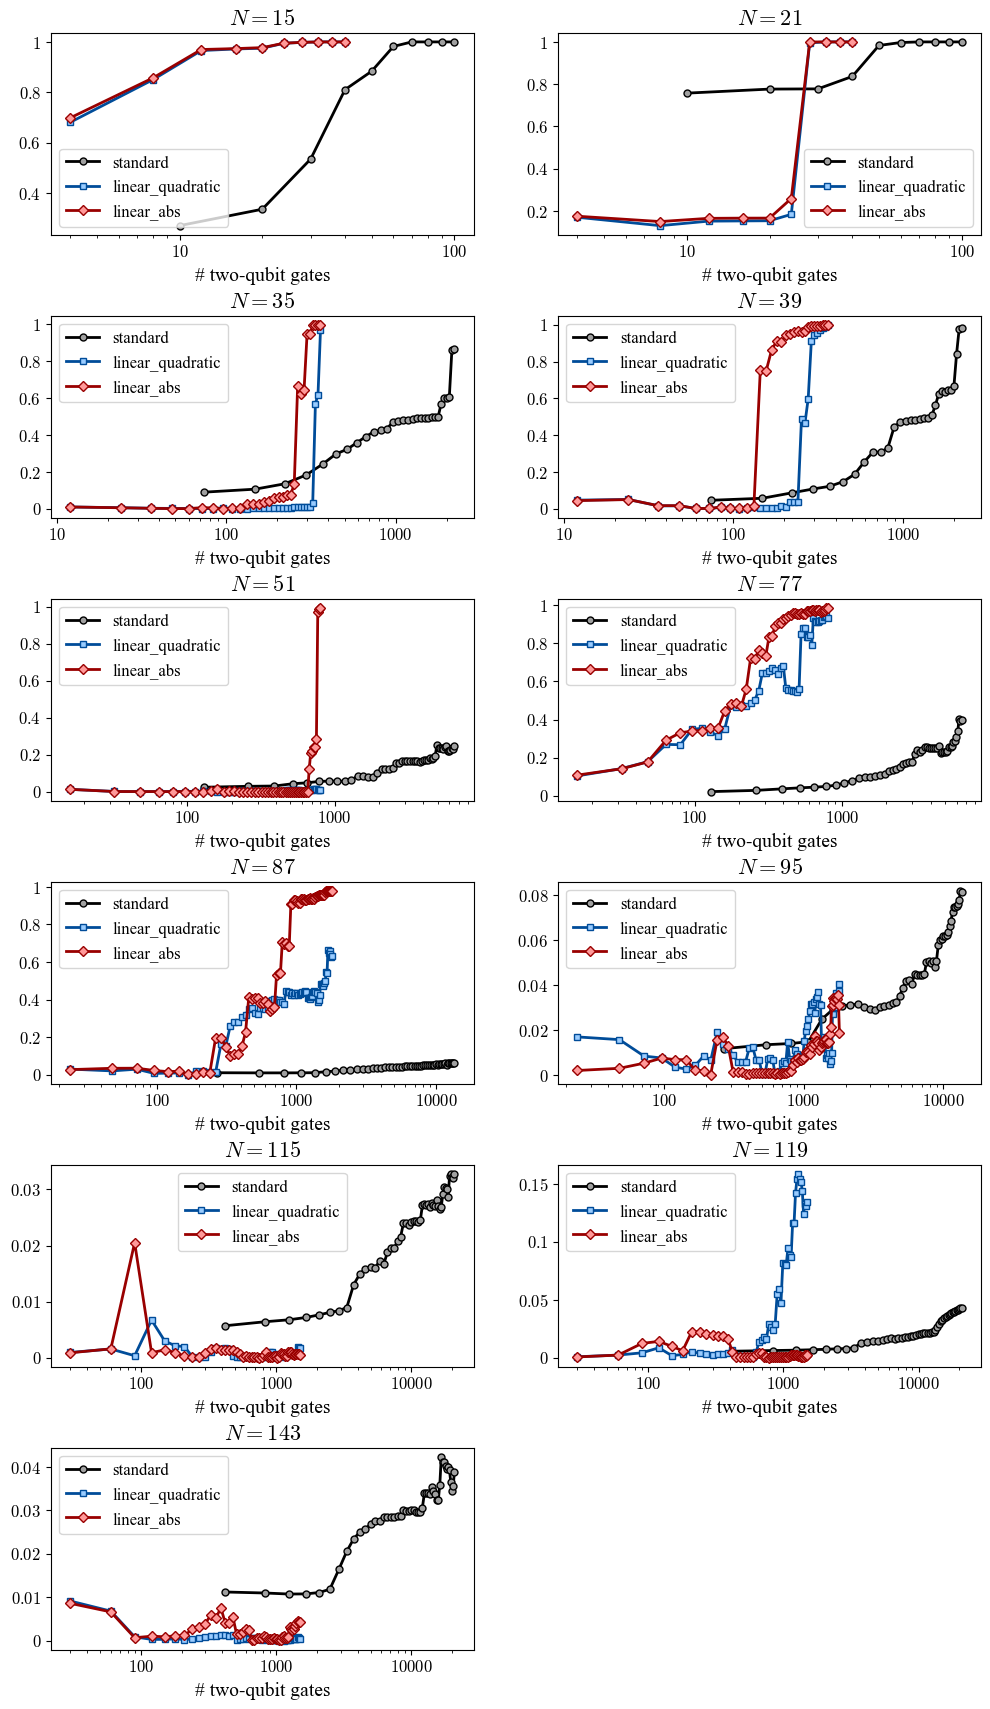

In [5]:
Ns = sorted(experiment_results['N'].unique())

ncols = 2
nrows = int(np.ceil(len(Ns)/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows))
fig.subplots_adjust(hspace=0.4)

for i, N in enumerate(Ns):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'num_2qub_gates', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )
        ax.set_xscale('log')

    ax.set_xlabel('# two-qubit gates')
    if j==0:
        ax.set_ylabel('Fidelity')

    ax.set_title(f'$N = {N}$')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    
    ax.legend()

for k in range(len(Ns), len(axs.flatten())):
    axs.flatten()[k].remove()

plt.savefig('plots/fidelity_gates_raw_logscale.pdf', format='pdf', bbox_inches='tight')